In [1]:
import numpy as np
import pandas as pd

from preprocessor import Preprocessor, PreprocessorCLI
from clusterer import Clusterer
from forecaster import ClusterForecaster, WorkloadGenerator

import glob
from pathlib import Path

from matplotlib import pyplot as plt

### Workload Generation
Using sample tpcc data

In [2]:
query_log_folder = "/home/mkpjnx/repos/QueryBot5000/data/extracted/extended/"
pgfiles = glob.glob(str(Path(query_log_folder) / "postgresql*.csv"))

preprocessor = Preprocessor(pgfiles, PreprocessorCLI._PG_LOG_COLUMNS)


Read dataframe: 14.08 s
Extract queries: TODO(WAN): Disabled SQL format for being too slow.
Extract queries: 8.22 s
Extract parameters: 6.32 s
Substitute parameters into query: 20.38 s
Parse query: 22.07 s


In [3]:
model_path = "models"

cluster_interval = pd.Timedelta(seconds=.25)
df = preprocessor.get_grouped_dataframe_interval(cluster_interval)

df.index.rename(["query_template", "log_time_s"], inplace=1)

print("Clustering query templates.")
clusterer = Clusterer(df, cluster_interval=cluster_interval)
assignment_df = clusterer.assignment_df

# join to cluster and group by
joined = df.join(assignment_df)
joined["cluster"].fillna(-1, inplace=True)
clustered_df = joined.groupby(["cluster", "log_time_s"]).sum()
clustered_df

Clustering query templates.


count
cluster log_time_s                             
0       2021-12-06 14:23:32-05:00           616
        2021-12-06 14:23:32.250000-05:00   1699
        2021-12-06 14:23:32.500000-05:00   2344
        2021-12-06 14:23:32.750000-05:00   1943
        2021-12-06 14:23:33-05:00          2367
...                                         ...
        2021-12-06 14:24:32.750000-05:00   3328
        2021-12-06 14:24:33-05:00          1265
1       2021-12-06 14:23:32-05:00            29
2       2021-12-06 14:24:33-05:00             9
3       2021-12-06 14:23:31.750000-05:00      1

[248 rows x 1 columns]

In [4]:
# only train with the top 5 clusters
TOP_K_CLUSTERS = 2
cluster_totals = clustered_df.groupby(level=0).sum().sort_values(by='count', ascending=False)
cluster_totals.iloc[:TOP_K_CLUSTERS]

,count
cluster,
0,723308
1,29


In [5]:
import importlib
import forecaster
importlib.reload(forecaster)
from forecaster import ClusterForecaster

In [6]:
pred_interval = pd.Timedelta(seconds=1)
pred_horizon = pd.Timedelta(seconds=5)

cluster_forecaster = ClusterForecaster(
    clustered_df,
    prediction_seqlen=10,
    prediction_interval=pred_interval,
    prediction_horizon=pred_horizon,
    save_path=model_path,
    top_k=5,
    override=True)

Training on cluster time series..
training model for cluster 0
Training with 63 samples, 10 epochs:
[LSTM FIT]epoch:   1 loss: 0.00466228
[LSTM FIT]epoch:   2 loss: 0.09767193
[LSTM FIT]epoch:   3 loss: 0.19148356
[LSTM FIT]epoch:   4 loss: 0.03185757
[LSTM FIT]epoch:   5 loss: 1.78058124
[LSTM FIT]epoch:   6 loss: 0.02628156
[LSTM FIT]epoch:   7 loss: 0.00190569
[LSTM FIT]epoch:   8 loss: 1.85031700
[LSTM FIT]epoch:   9 loss: 0.03594513
[LSTM FIT]epoch:  10 loss: 0.01160441
[LSTM FIT]epoch:  10 loss: 0.0116044115
training model for cluster 1
Training with 63 samples, 10 epochs:
[LSTM FIT]epoch:   1 loss: 0.00100149
[LSTM FIT]epoch:   2 loss: 0.00010598
[LSTM FIT]epoch:   3 loss: 0.00190880
[LSTM FIT]epoch:   4 loss: 0.00004711
[LSTM FIT]epoch:   5 loss: 0.00030231
[LSTM FIT]epoch:   6 loss: 0.00043897
[LSTM FIT]epoch:   7 loss: 0.00022428
[LSTM FIT]epoch:   8 loss: 0.00023303
[LSTM FIT]epoch:   9 loss: 0.00049877
[LSTM FIT]epoch:  10 loss: 0.00004880
[LSTM FIT]epoch:  10 loss: 0.00004

In [7]:
min_time = clustered_df.index.get_level_values(1).min()
max_time = clustered_df.index.get_level_values(1).max()

In [8]:
# predict over a 1 minute interval
pred_start = min_time
pred_end = max_time + pred_horizon

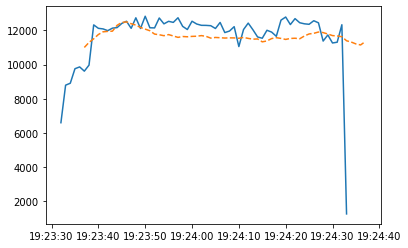

In [9]:
cluster = 0

result = cluster_forecaster.predict(clustered_df, cluster, pred_start, pred_end)

expected = clustered_df[clustered_df.index.get_level_values(0) == cluster].droplevel(0).resample(pred_interval).sum()
expected = expected[pred_start:(pred_end - pd.Timedelta(milliseconds = 1))]

# result
plt.plot(expected)
plt.plot(result, "--")
plt.show()


In [10]:
wg = WorkloadGenerator(preprocessor, assignment_df)
wg.get_workload(cluster, result.sum())

query
SELECT I_PRICE, I_NAME , I_DATA FROM item WHERE I_ID = '72869'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           119970
SELECT S_QUANTITY, S_DATA, S_DIST_01, S_DIST_02, S_DIST_03, S_DIST_04, S_DIST_05, S_DIST_06, S_DIST_07, S_DIST_08, S_DIST_09, S_DIST_10 FROM stock WHERE S_I_ID = '56677' AND S_W_ID = '1' FOR UPDATE                                                                                                             

In [11]:
#workload.to_csv("predicted_workload.csv")